### Submission Instructions

Just fill in the markdown and code cells below with your arguments and functions, and run the Python lines given. Make sure the notebook works fine by executing `Kernel/Restart & Run All`.
  
Once the notebook is ready,
1. Create a folder named `ftdl_last_name1_last_name2` with the team's last names.

2. Put in that folder:

* a file `mp_ftdl_last_name1_last_name2.ipynb` with the cells below completed. Make sure it works by executing Kernel/Restart & Run All.
* a file `mp_ftdl_last_name1_last_name2.html` with an html rendering of the previous .ipynb file (just apply File / Download as HTML after a correct run of Kernel/Restart & Run All).
* a file `mp_ftdl_last_name1_last_name2.pdf` with a pdf print of the html file **without any code**.

3. Compress the folder to a `ftdl_last_name1_last_name2.7z` 7z (or zip) file.

**Very important!!!**

Make sure you follow the file naming conventions above; the miniproject won't be graded until that is so.

## Recommendations in notebook writing

Notebooks are a great tool for data and model exploration. But in that process a lot of Python garbage can get into them as a consequence of the trial and error process.

But once these tasks are done and one arrives to final ideas and insights on the problem under study, the notebook should be **thoroughly cleaned** and the notebook should **concentrate on the insights and conclussions** without, of course, throwing away the good work done.

Below there are a few guidelines about this.

* Put the useful bits of your code as functions on a **Python module** (plus script, if needed) that is imported at the notebook's beginning. 
* Of course that module should be **properly documented** and **formatted** (try to learn about PEP 8 if you are going to write a lot of Python).
* Leave in the notebook **as little code as possible**, ideally one- or two-line cells calling a function, plotting results or so on.
* **Avoid boilerplate code**. If needed, put it in a module.
* Put on the notebook some way to **hide/display the code** (as shown below).
* The displayed information **should be just that, informative**. So forget about large tables, long output cells, dataframe or array displays and so on.
* Emphasize **insights and conclusions**, using as much markdown as needed to clarifiy and explain them.
* Make sure that **number cells consecutively starting at 1.**
* And, of course, make sure that **there are no errors left**. To avoid these last pitfalls, run `Kernel\Restart Kernel and Run All Cells`.

And notice that whoever reads your notebook is likely to toggle off your code and consider just the markdown cells. Because of this, once you feel that your notebook is finished,
* let it rest for one day, 
* then open it up, toggle off the code 
* and read it to check **whether it makes sense to you**.

If this is not the case, **the notebook is NOT finished!!!**

Following these rules you are much more likely to get good grades at school (and possibly also larger bonuses at work).

**IMPORTANT AND JUST IN CASE: before turning in your work, please REMOVE FROM IT THE PREVIOUS TWO CELLS**

In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# Wind Energy Prediction
We want to predict the wind energy production on a farm using wind speed and direction information.

The aim of this wind power forecasting problem is to predict the wind power generation 24 h ahead for a wind farm in Australia.

Attribute Information:
The features include forecasts of the projections of the wind vector on the west-east (U) and south-north (V) axes,at two heights, 10 and 100 m above ground level, plus the corresponding absolute wind speeds.

Data for a 10 month period are given in a csv file with headers

`TIMESTAMP,TARGETVAR,U10,V10,U100,V100,v10,v100`

where

* TIMESTAMP contains day/hour information.
* TARGETVAR is the wind energy production normalized to a [0, 100] range.
* U10,V10,U100,V100 are the U and V wind components in m/s at heights 10 and 100.
* v10,v100 are the absolute wind speeds in m/s at heights 10 and 100.

The dataset we will use is an adaptation of those available in the Kaggle page https://www.kaggle.com/c/GEF2012-wind-forecasting. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import time
import pickle
import gzip

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

In [3]:
start_time = time.time()

## Data Loading

The dataset is preloaded in the sciki-learn library and as it is shown in the next output, it contains 6576 observations and 7 variables, including the target.

In [4]:
df_0 = pd.read_csv('.\w_e.csv', index_col=0, parse_dates=True)
l_vars = df_0.columns[1 : ]
print(l_vars)
df = df_0[l_vars]
df['target'] = df_0['TARGETVAR']

print ("nFilas: %d\tnColumnas: %d\n" % (df.shape[0], df.shape[1]) )
print ("Columnas:\t", np.array(df.columns))

Index(['U10', 'V10', 'U100', 'V100', 'v10', 'v100'], dtype='object')
nFilas: 6576	nColumnas: 7

Columnas:	 ['U10' 'V10' 'U100' 'V100' 'v10' 'v100' 'target']


# Data Exploration, Visualization and Correlations

In this section, we will present a descriptive analysis over the entire dataset to know the nature of data.

* Compute descriptive statistics.
* Draw boxplots, pairplots and histograms.
* Compute and present correlations. 

Give your comments and conclusions after each step.

## Descriptive analysis

We first showed a sample of data that allows us to know its format. We can see that data can be seen as a timeseries, because each observation belongs to a different time instant. 

In [5]:
df.head()

,U10,V10,U100,V100,v10,v100,target
TIMESTAMP,,,,,,,
2012-01-01 01:00:00,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,0.000000
2012-01-01 02:00:00,2.521695,-1.796960,3.344859,-2.464761,3.096451,4.154892,5.487912
2012-01-01 03:00:00,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,11.023400
2012-01-01 04:00:00,2.457504,-0.143642,3.215233,-0.355546,2.461699,3.234831,16.511606
2012-01-01 05:00:00,2.245898,0.389576,2.957678,0.332701,2.279435,2.976332,15.694013


In the next cell, we show a descriptive analysis of all variables in the dataset. The count suggests that there are not missing values in our dataset because all variables have the same number of values. In addition, the quartiles metrics show that there is no rextremely rare values and value ranges appear to be reasonable.

In [6]:
df.describe().round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
U10,6576.0,0.93,2.55,-7.49,-1.09,0.78,2.48,11.12
V10,6576.0,-0.25,2.99,-9.99,-2.38,0.01,1.96,9.07
U100,6576.0,1.59,4.25,-10.91,-1.77,1.41,4.64,16.99
V100,6576.0,-0.48,5.13,-15.29,-4.80,0.30,3.61,14.31
v10,6576.0,3.63,1.78,0.12,2.20,3.33,4.79,11.74
v100,6576.0,6.33,2.65,0.08,4.43,6.18,8.00,18.49
target,6576.0,30.99,29.57,0.00,5.83,21.36,50.16,99.95


## Boxplots

Next, we are going to check the existence of outliers in each of the variables using boxplots. The data has been normalized in order to have uniform ranges in the graphics.

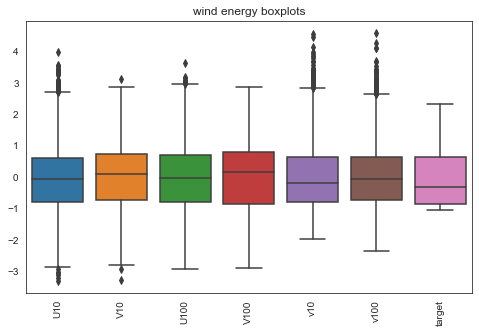

In [7]:
df_normalized = (df - df.mean()) / df.std() 

plt.figure( figsize=(8, 5))
sns.set_style("white")
bx_plot = sns.boxplot(data=df_normalized)
plt.title("wind energy boxplots")
plt.xticks(rotation=90)
plt.show()

As we can see in the figure above, the variables *v10* and *v100* are the ones with more outliers, points past the main lines.

## Histograms and scatterplots

Following, we draw scatterplots that allow to analyze the existence or not of linear correlation between all variables. Likewise, histograms are exposed showing the distribution of each variable.

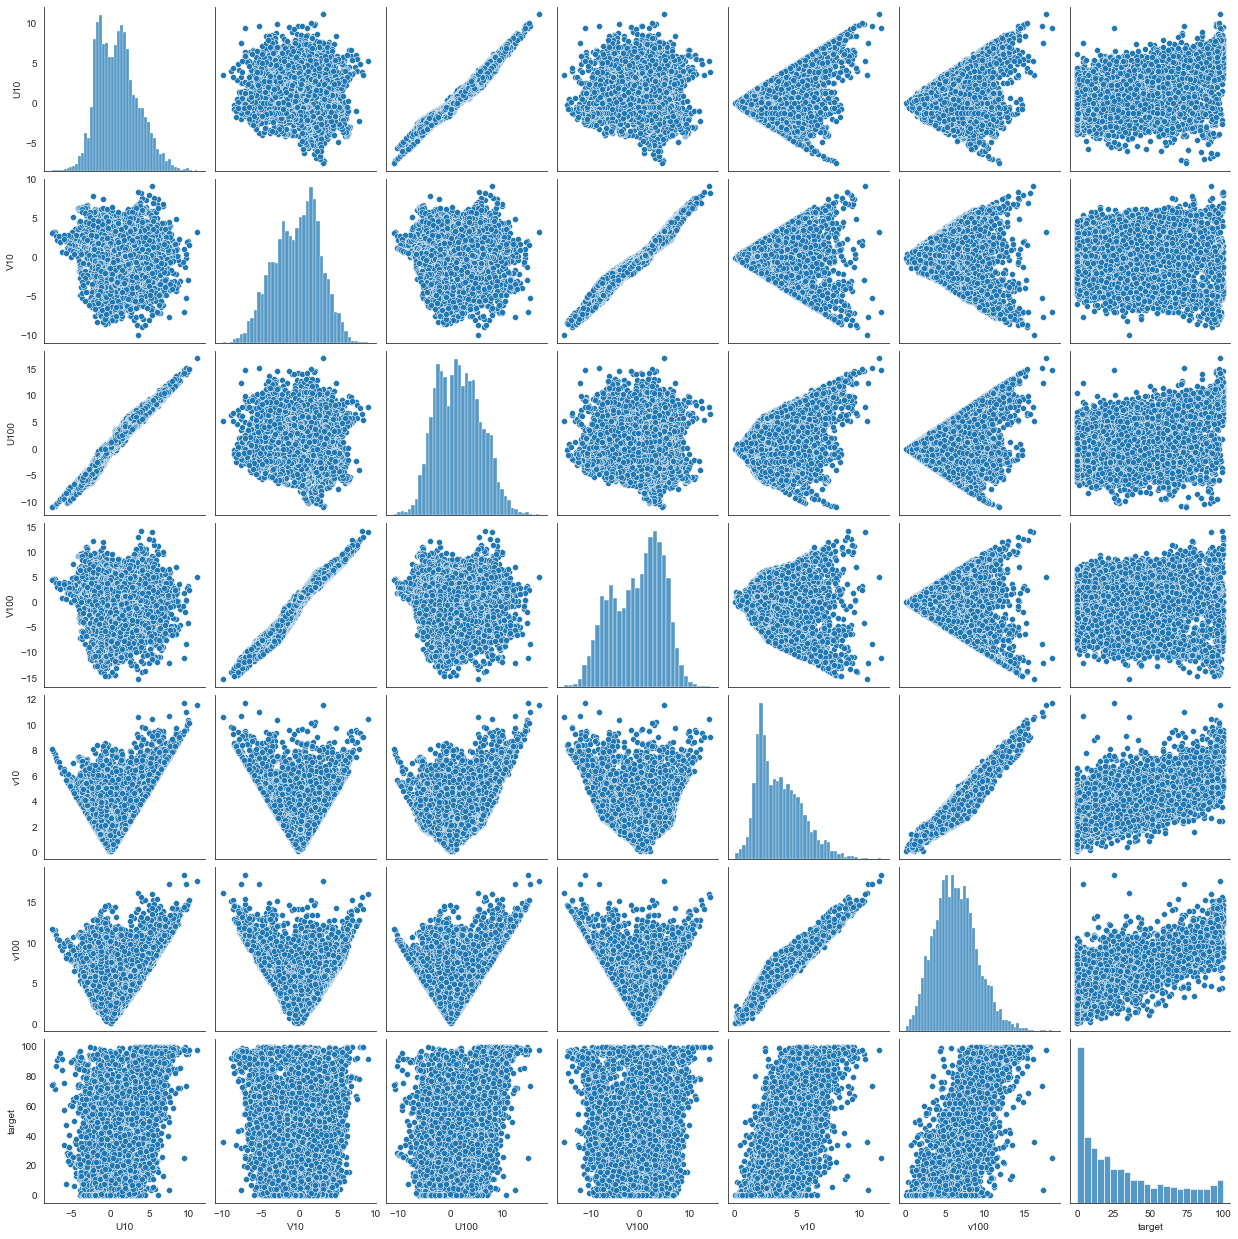

In [8]:
num_vars_to_show = 6 
pair_plot = sns.pairplot(df[list(l_vars)[:num_vars_to_show] + ['target']])
plt.show()

It seems that there are no variables which have a linear relationship with the target. However, there is a clearly linear relationship between some of the variables. For intance, between $(v10, v100)$, $(V10, V100)$ and $(U10, U100)$. We need to have this into account in the model development section.

## Correlations

In order to check the correlations seen between predictable variables in the last graphic, next it is shown the correlation matrix which helps us determine analytically the variables that are linearly correlated. As it was said before, the pairs of variables $(v10, v100)$, $(V10, V100)$ and $(U10, U100)$ are highly correlated.

In [9]:
df.corr().round(decimals=3)

,U10,V10,U100,V100,v10,v100,target
U10,1.000,-0.098,0.981,-0.058,0.441,0.392,0.377
V10,-0.098,1.000,-0.133,0.981,-0.162,-0.257,-0.166
U100,0.981,-0.133,1.000,-0.095,0.394,0.364,0.365
V100,-0.058,0.981,-0.095,1.000,-0.172,-0.279,-0.177
v10,0.441,-0.162,0.394,-0.172,1.000,0.915,0.706
v100,0.392,-0.257,0.364,-0.279,0.915,1.000,0.745
target,0.377,-0.166,0.365,-0.177,0.706,0.745,1.000


The following matrix shows the same correlation matrix seen before but using a color palette that allows high correlations to be identified more quickly, so that red is associated with highly correlated variables and blue, the opposite.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

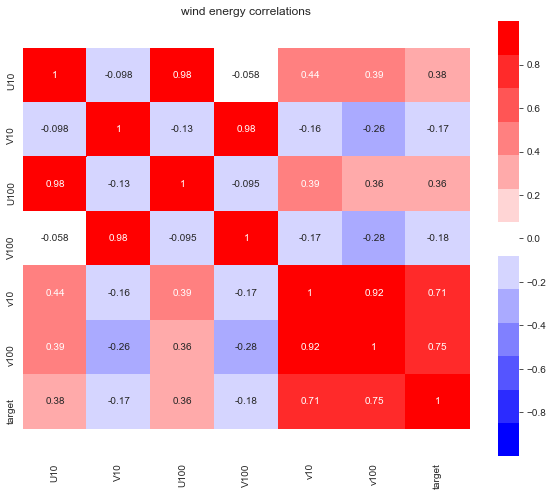

In [11]:
n_colors = 13
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

fig = plt.figure( figsize=(10, 8))
plt.title('wind energy correlations')
h_map = sns.heatmap(df.corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap,
                    annot=True,
                    xticklabels=list(df.columns),
                    yticklabels=list(df.columns))
plt.xticks(rotation=90) 

cbar = h_map.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

## Overall conclusions

There are highly correlated variables which is what it was expected by their meanings. In order to perform simple models like LinearRegression it would be correct to eliminate one of the correlated variables due to the difficulty it can cause when calculating inverse matrices.
However, in MLP and SVM this is not a problem because is the model itself that is in charge of dealing with this issue.

# Models

In this section we focus on the development of machine learning models that fits the data described before. The main goal is to build basic neurals and support vector regressors. As we must always have a base model to benchmark our results, we start by evaluating a simpler model.

The simplest of the models seen in class are the linear regressors, excluding the constant models which do not really represent benchmarks. However, when some features are correlated, a regression model won´t work because the analytical expression is not invertible. In this dataset, as we have already observed, many of the variables are highly correlated so we can not use simple linear regression. On the other hand, Ridge regression controls this issue by introducing a regularization param, reason why we are going to use as base model a Ridge regressor.

## Ridge Regression

To get started, we define and fit a first and simply model so that we can then compare the results and see if there is some improvement or not. As the objective of this model is to compare with the neural and support vector models we are going to reproduce the steps requested for the implementation of these two in the projects instructions. 

To get a more realistic evaluation, we implement Cross Validation over 3 random folds. Likewise, we use GridSearchCV to explore and find the best `alpha`.

In [12]:
sc = StandardScaler()

x = sc.fit_transform(df[l_vars])
y = df[['target']]

In [13]:
n_folds = 3
kf = KFold(n_folds, shuffle=False)

l_alpha = [2.**k for k in range(-6, 10)]
param_grid = {'alpha': l_alpha}

lr_m = Ridge()
ridge_alpha_search = GridSearchCV(lr_m, 
                                  param_grid=param_grid, 
                                  cv=kf, 
                                  scoring='neg_mean_absolute_error',
                                  n_jobs=-1, 
                                  verbose=1)

ridge_model = ridge_alpha_search.fit(x, y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    3.4s finished


We check the adequacy of the best hyperparameter and plot the CV errors with respect to `alpha`.

alpha_range: 0.02 - 512.00
alpha = 128.00
best_cv_mae = 15.369


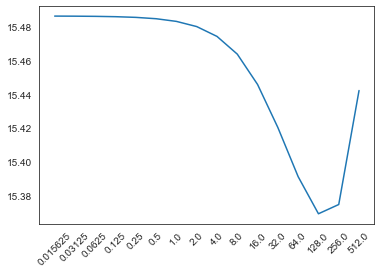

In [14]:
print("alpha_range: %.2f - %.2f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('alpha = %.2f' % (ridge_alpha_search.best_params_['alpha']))
print('best_cv_mae = %.3f' % (-ridge_alpha_search.best_score_))

plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -ridge_alpha_search.cv_results_['mean_test_score'])

In [15]:
best_ridge_alpha = ridge_alpha_search.best_params_['alpha']
best_ridge = ridge_model.best_estimator_

scores = cross_val_score(best_ridge, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))

mae_mean: 15.369		mae_std: 1.082


The best alpha found was 128.00 and the model has a mean absolute error of 15.536. Let´s analyze the preditions. In the next graphic we show the predicted wind energy values by Ridge against the real ones.

In [16]:
y_ridge_pred = np.clip(cross_val_predict(best_ridge, x, y, cv=kf), 0., 200.)

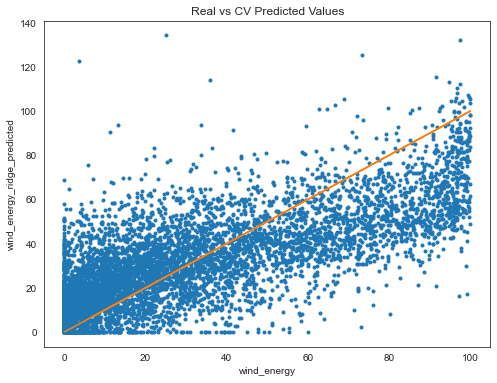

In [17]:
plt.figure(figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_ridge_predicted')
_ = plt.plot(y, y_ridge_pred, '.', y, y, '-')

In the next two we show the error distributions in the left histogram and the scatter plot crresponding to the erros and the real y's.

mae: 15.039


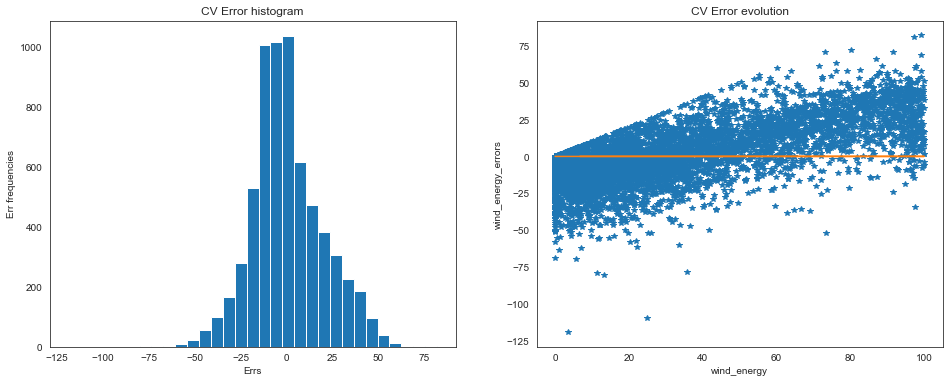

In [18]:
err = y - y_ridge_pred
print("mae: %.3f" % (abs(err).mean()) )

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("wind_energy_errors")
_ = plt.plot(y, err, '*', y, 0.*y, '-')

plt.show()

In [ ]:
#TODO:

As we can see in the first scatter plot shown, the values are vey disperse over the diagonal, which means that the predicted values are not so close to the real ones as we would wanted. Moreover, if we look at the histogram below, that shows the error distribution, we can se that even when most of them are close to zero, there is a huge amount disperse between -50 and 75, in this case there are more positive error acumcumulated. This means that the model gets wrong predicting over and below the real values. The same suggests the second scatter plot shown at the right, where the plotted points are distant from the axis 0. All these observations are evidenced in the error that we have obtained in the model. Let´s try to improve this result trhough the dvelopments of models like Multilayer Perceptrons (MLP) and Support Vector Machines (SVM).

# MLPRegressor

We perform a CV MLPRegressor using GridSearch to optimize hyperparameters and a pipelined MLPR over three folds over the entire sample. Initially, we selected as optimizable params the alpha, the hidden layer sizes and the maximum number of iterations. A first search was executed taking into account these three parameters, however, it was seen that the maximum number of iterations do not has a direct impact on results and it delayed the training stage, so we decide to fix it to 10000 iterations, which was the best hyperparameter found, and re-executed the search algorithm taking into account just the other two: alpha and hidden layer size. 

In [19]:
sc = StandardScaler()

x = sc.fit_transform(df[l_vars])
y = df[['target']]

In [20]:
# n_folds = 3
# kf = KFold(n_folds, shuffle=False)

mlpr_kf =  MLPRegressor(activation='relu', 
                     solver='lbfgs', 
                     early_stopping=True,
                     tol=1.e-3, 
                     max_iter=10000)

regr_kf = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('mlp', mlpr_kf)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr_kf,
                                             transformer=y_transformer)

l_alpha = [10.**k for k in range(-6, 7)]
param_grid = {
    'regressor__mlp__alpha': l_alpha, 
    'regressor__mlp__hidden_layer_sizes': [(20,), (20, 20), (20, 20, 20)]    
}

cv_mlp = GridSearchCV(inner_estimator, 
                    param_grid=param_grid, 
                    cv=kf, 
                    scoring='neg_mean_absolute_error',
                    return_train_score=True,
                    refit=True,
                    n_jobs=-1, 
                    verbose=1)

t_0 = time.time()
cv_mlp.fit(x, y)
t_1 = time.time() 
print("\nmlp_grid_search_time: %.2f" % ((t_1 - t_0)/60.))
        
# saving alpha_search in a pickle    
f_name = 'mlp_search_results_kf.joblib'
joblib.dump(cv_mlp, f_name, compress=3)

Fitting 3 folds for each of 39 candidates, totalling 117 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed: 14.3min finished



mlp_grid_search_time: 14.49


['mlp_search_results_kf.joblib']

## Analyzing GridSearchCV results

In this section the results of the the GridSearchCV are analyzed in function of the mean absolute error (mae). 
The possible params values are listed below and also, the params which conducted to the model with the lowest error. The alpha selected was 10.00 and (20, 20) as hidden layers size.

Check the adequacy of the best hyperparameters.

In [21]:
cv_mlp = joblib.load('mlp_search_results_kf.joblib')

print("alpha_range: %.2f - %.2f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('best_alpha = %.2f' % (cv_mlp.best_params_['regressor__mlp__alpha']))
print('----------')

print(f"layer_sizes = {[(20,), (20, 20), (20, 20, 20)]}" )
best_size = cv_mlp.best_params_['regressor__mlp__hidden_layer_sizes']
print(f'best_hidden_layer_sizes = {best_size}')
print('----------')

# print(f"max_iter range: 1000 - 100000")
# best_max_iter = cv_mlp.best_params_['regressor__mlp__max_iter']
# print(f"best max_iter = {best_max_iter}")
# print('----------')

print('best_cv_mae = %.3f' % (-cv_mlp.best_score_))

alpha_range: 0.00 - 1000000.00
best_alpha = 10.00
----------
layer_sizes = [(20,), (20, 20), (20, 20, 20)]
best_hidden_layer_sizes = (20, 20, 20)
----------
best_cv_mae = 13.430


The table below shows the five configurations which reached the highest performance during GridSearch. It can be seen that the best model reached an score

In [22]:
mlp_search = pd.DataFrame.from_dict(cv_mlp.cv_results_)
mlp_search.sort_values(by='mean_test_score', ascending=False)[['param_regressor__mlp__alpha',\
                                                                      'param_regressor__mlp__hidden_layer_sizes',\
                                                                      'mean_test_score',
                                                                       'mean_train_score']][:5]

,param_regressor__mlp__alpha,param_regressor__mlp__hidden_layer_sizes,mean_test_score,mean_train_score
23,10,"(20, 20, 20)",-13.430221,-11.785190
21,10,"(20,)",-13.503010,-12.355759
22,10,"(20, 20)",-13.512407,-12.026106
6,0.0001,"(20,)",-13.592606,-11.521134
15,0.1,"(20,)",-13.766276,-11.551889


In the following graphic we plot the errors with respect to *alpha*. It can be seen that while the higher the alpha, also increments the absolute error. 

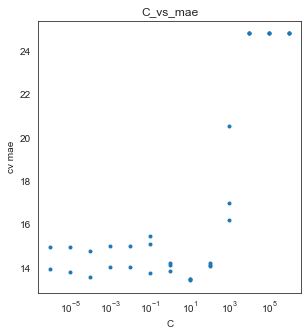

In [23]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.title('C_vs_mae')
plt.xlabel('C')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot(mlp_search['param_regressor__mlp__alpha'], -mlp_search['mean_test_score'], '.')

In [24]:
# plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
# _ = plt.plot(-cv_mlp.cv_results_['mean_test_score'])

## Testing the MLPR model

We test the model over the entire dataset using the function `cross_val_predict`. In addtion, we plot the predicted and the real values and calculate the MAE.

In [25]:
y_pred_mlp_cv = np.clip(cross_val_predict(cv_mlp.best_estimator_, x, y, cv=kf, n_jobs=-1), 0., 200.)

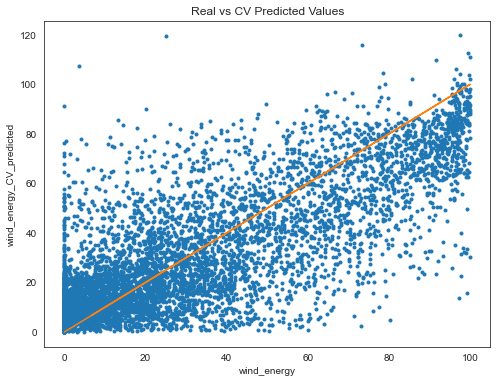

In [26]:
plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_CV_predicted')
_ = plt.plot(y, y_pred_mlp_cv, '.', y, y, '-')

In [27]:
from sklearn.metrics import mean_absolute_error

print("MAE: %.3f" % mean_absolute_error(y, y_pred_mlp_cv))

MAE: 13.441


This model has obtained a mean absolute error of 13,642, which is lower that the one reached by the Ridge regressor but it can be considered still a high error. So, this means this model outperforms the benchmark selected. However, the points in the graphic above remains very disperse over the diagonal.

## MLP Residual histograms and relationship with targets

In this section we show two graphics related to the model errors. In the first one we show the error distribution and in the second one the real values against the erros in each of the observation in the dataset.

mae: 13.441


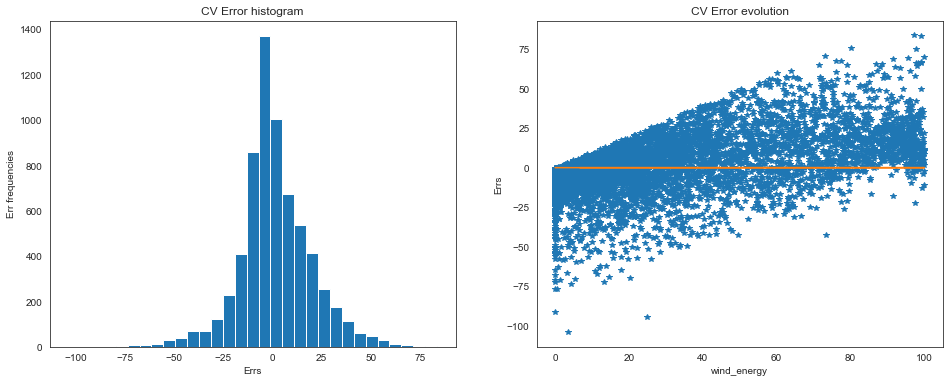

In [28]:
err = y - y_pred_mlp_cv

print("mae: %.3f" % (abs(err).mean()) )

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
_ = plt.plot(y, err, '*', y, 0.*y, '-')

plt.show()

The first graphic shows that errors have mean close to cero, but they do not look normally distributed. There are more observations with positive error than negative which means that in most of the cases the predicted value is below the real one. This translated to natural language, means that most of the time the model predicts greater wind energy that the real one. 

On the other hand, the second graphic shows that the model is more exact in values close to the media, as the first one also showed, however, in extremes values, high or small, the model gets a greater error, which means that the model gets wrong predicting high and small wind energy values. This figure also shows that there are more points above the zero line than below, confirming what express the histogram.

# SV Regressor

This section is dedicated to the SV Regressor. We will be training a SV regresors with gaussian kernels, reason why we have to set hyperparameters `C, gamma` and the `epsilon` insensitivity. We perform a GridSearchCV to find the parameters which best fit data. As we are going to optimize three values, the search space increases considerably so we need to downsample the original data to values every three hours, making the dataset smaller.

In the next output we show a sample of the reduced data.

In [29]:
sample_df = df.resample('3H').first()
sample_df.head(10)

,U10,V10,U100,V100,v10,v100,target
TIMESTAMP,,,,,,,
2012-01-01 00:00:00,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,0.000000
2012-01-01 03:00:00,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,11.023400
2012-01-01 06:00:00,1.986038,0.796304,2.655406,0.882648,2.139730,2.798258,16.878113
2012-01-01 09:00:00,-1.380191,2.903624,-3.048145,6.041520,3.214959,6.766916,15.318109
2012-01-01 12:00:00,-2.340389,0.617855,-6.095209,1.564929,2.420571,6.292899,14.782445
2012-01-01 15:00:00,-2.020323,-0.455396,-5.185562,-1.845935,2.071012,5.504319,24.104877
2012-01-01 18:00:00,-0.234062,-3.575916,0.028920,-8.864540,3.583568,8.864587,25.345362
2012-01-01 21:00:00,0.431304,-3.920464,1.175177,-8.187682,3.944117,8.271588,73.545717
2012-01-02 00:00:00,1.468088,-5.200273,2.254640,-7.688174,5.403529,8.011955,76.045483


After reducing, the new dataset have 2193 observations with the same 6 variables.

In [30]:
x_sample = sample_df[l_vars].values
y_sample = sample_df[['target']].values.reshape(-1,)
num_patterns, dim = x_sample.shape
num_patterns, dim

(2193, 6)

In [31]:
l_C     = [10.**k for k in range(-3, 4)] 
l_gamma = list( np.array([2.**k for k in range(-2, 7)]) / dim)
l_epsilon = [2.**k for k in range(-6, 0)]

param_grid ={'regressor__svr__C': l_C,
             'regressor__svr__gamma': l_gamma,
             'regressor__svr__epsilon': l_epsilon}

print("num_hyperparams", len(l_C) * len(l_gamma) * len(l_epsilon))

mm_sc = MinMaxScaler()
svr = SVR(kernel='rbf', 
          shrinking=False, 
          tol=1.e-3)

regr = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                       ('svr', svr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

sv = GridSearchCV(inner_estimator, 
                    param_grid=param_grid, 
                    cv=kf, 
                    scoring='neg_mean_absolute_error', 
                    refit=True,
                    n_jobs=-1,
                    return_train_score=True,
                    verbose=1)

t_0 = time.time()
sv.fit(x_sample, y_sample)
print("grid_search_time: %f segundos" % (time.time() - t_0))

f_pkl = open("sv_search_results.pkz", 'wb') 
pickle.dump(sv, f_pkl)
f_pkl.close()

num_hyperparams 378
Fitting 3 folds for each of 378 candidates, totalling 1134 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 1134 out of 1134 | elapsed:  9.5min finished


grid_search_time: 567.727030 segundos


In [32]:
f_pkl = open("sv_search_results.pkz", 'rb') 
sv = pickle.load(f_pkl)
f_pkl.close()

Next, the considered values of selected hyperparams are listed and also, the ones which got the best performance.

In [33]:
print("C_range: %.4f - %.0f" % (np.array(l_C).min(), np.array(l_C).max()))
print("\tbest_C:", sv.best_params_['regressor__svr__C']) 
print('--------')

print("gamma_range: %.5f - %.5f" % (np.array(l_gamma).min(), np.array(l_gamma).max()))
print("\tbest_gamma:", sv.best_params_['regressor__svr__gamma'])
print('--------')

print("epsilon_range: %.5f - %.3f" % (np.array(l_epsilon).min(), np.array(l_epsilon).max()))
print("\tbest_epsilon:", sv.best_params_['regressor__svr__epsilon'])
print('--------')

C_range: 0.0010 - 1000
	best_C: 1.0
--------
gamma_range: 0.04167 - 10.66667
	best_gamma: 5.333333333333333
--------
epsilon_range: 0.01562 - 0.500
	best_epsilon: 0.125
--------


The table below shows the the five configurations with the lower error sorted by performance. As we can see the best configuration reached a mae in test of 12.976. Although it is slower than the benchmark and the MLP regressor error, it remains high.

In [34]:
df_C_gamma_epsilon_search = pd.DataFrame.from_dict(sv.cv_results_)
df_C_gamma_epsilon_search.sort_values(by='mean_test_score', ascending=False)[['param_regressor__svr__C',\
                                                                      'param_regressor__svr__gamma',\
                                                                      'param_regressor__svr__epsilon',\
                                                                      'mean_test_score']][ : 5]

,param_regressor__svr__C,param_regressor__svr__gamma,param_regressor__svr__epsilon,mean_test_score
196,1,5.33333,0.125,-12.976252
169,1,5.33333,0.015625,-13.003942
249,10,2.66667,0.125,-13.019025
187,1,5.33333,0.0625,-13.019426
178,1,5.33333,0.03125,-13.023488


The next cell shows each of the hyperparameter in function of the error reached during training.

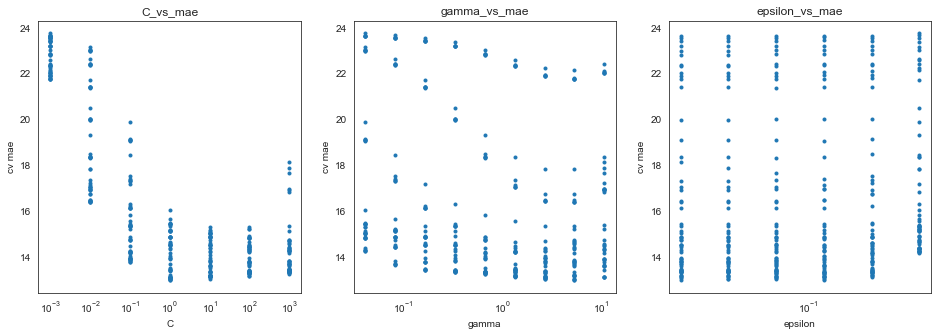

In [35]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.title('C_vs_mae')
plt.xlabel('C')
plt.ylabel('cv mae')
plt.xscale('log')
#plt.ylim(1.8, 2.2)
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__C'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 2)
plt.title('gamma_vs_mae')
plt.xlabel('gamma')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__gamma'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 3)
plt.title('epsilon_vs_mae')
plt.xlabel('epsilon')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__epsilon'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.show()

The first figure shows the `C` in functions of the errors reached during training. It can be seen that for smaller values of C the error is greater, and it goes down with mean values of `C`, we can also see that we `C` increase too much the error gets high again. The parameters `C` is associated to the regularization of the model, higher `C` means less regularization. The second one shows the `gamma` against the error. This parameter is related to the narrowness of the gaussians and the relation is not as clear as in the previous graphic. On the other hand, the third graphic which shows the parameter `epsilon` suggests that this parameter does not has a great incfluence on model results because the mae do not shows great changes.

In [36]:
best_estimator = sv.best_estimator_

scores = cross_val_score(best_estimator, x_sample, y_sample, scoring="neg_mean_absolute_error", cv=kf, n_jobs=2)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))

mae_mean: 12.976		mae_std: 1.296


In [37]:
from sklearn.model_selection import cross_val_predict

y_pred_svr = np.clip(cross_val_predict(best_estimator, x_sample, y_sample, cv=kf, n_jobs=-1), 0., 200.)

The next graphic shows the predicted values by the SVR model against the real wind energy values. As it can be seen and the high error already seen suggests, the scatter plots are very distant from the diagonal. This means that the real values and the predicted ones are different from each other and the model is not very accurate. 

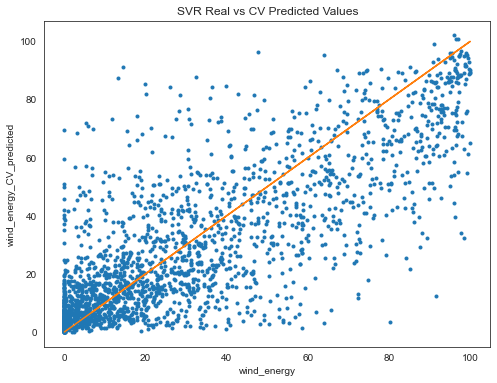

In [38]:
plt.figure( figsize=(8,6))

plt.title('SVR Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_CV_predicted')
_ = plt.plot(y_sample, y_pred_svr, '.', y_sample, y_sample, '-')

Let´s analyze the erros distribution.

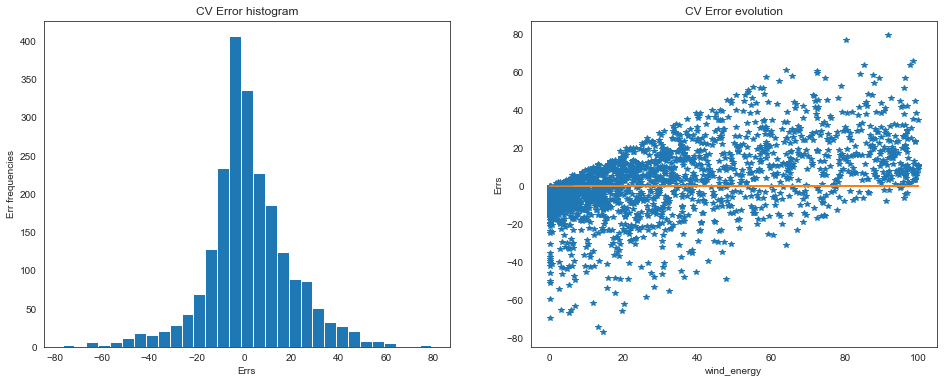

In [39]:
err = y_sample - y_pred_svr

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
_ = plt.plot(y_sample, err, '*', y, 0.*y, '-')

plt.show()

Analyzing the histogram that shows the distribution of the errors, we can see that it is very similar to that seen previously in the MLP model. Therefore, it can be said that although it is true that the mean of the errors is close to zero, the model gets wrong for multiple observations. For small energy values the error is negative, which means that the predicted value is greater than the real value of the wind energy, while for large energy values the error is positive. From this it can be concluded that the model for small values is wrong above and for large values is wrong below, giving predictions closer to a middle range.

# MLPR and SVR comparison

In this section both models, the MLPR and the SVR will be compared in terms of error. As we have said before, the SVR has a lower error in test than the MLP.

In [40]:
print("mlpr_mae: {0:.3f}".format(mean_absolute_error(y, y_pred_mlp_cv)))
print("svr_mae: {0:.3f}".format(mean_absolute_error(y_sample, y_pred_svr)))

mlpr_mae: 13.441
svr_mae: 12.975


In the next two figures we show, as we have done before for each model, the predicted values agins the real ones.

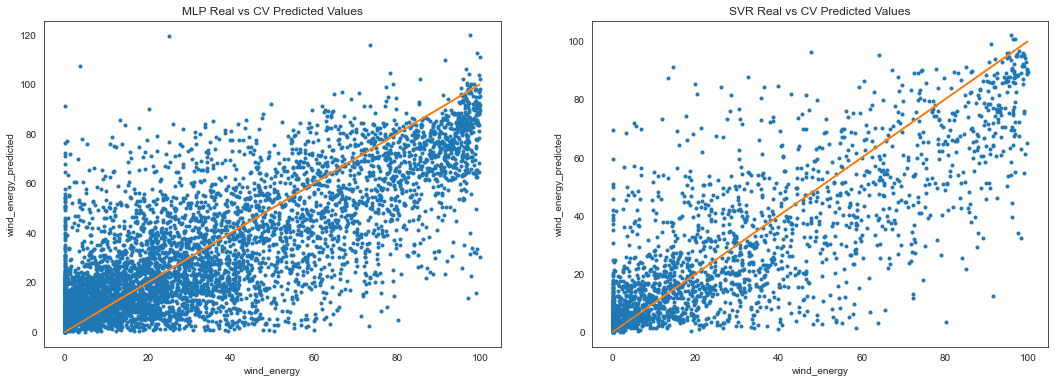

In [41]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
plt.title('MLP Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_predicted')
_ = plt.plot(y, y_pred_mlp_cv, '.', y, y, '-')

plt.subplot(1, 2, 2)
plt.title('SVR Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_predicted')
_ = plt.plot(y_sample, y_pred_svr, '.', y_sample, y_sample, '-')

Taking into account that the data sets are slightly different, when analyzing the first two graphs it can be said that they are quite similar. However, we can see that in the case of MLP there are values farther away from the diagonal line that may be affecting the metric, where a very high value was predicted. If we look at the width of the point cloud, in both cases it is very similar.

And in the next four, the error distribution and the scatter plots with errors and real values.

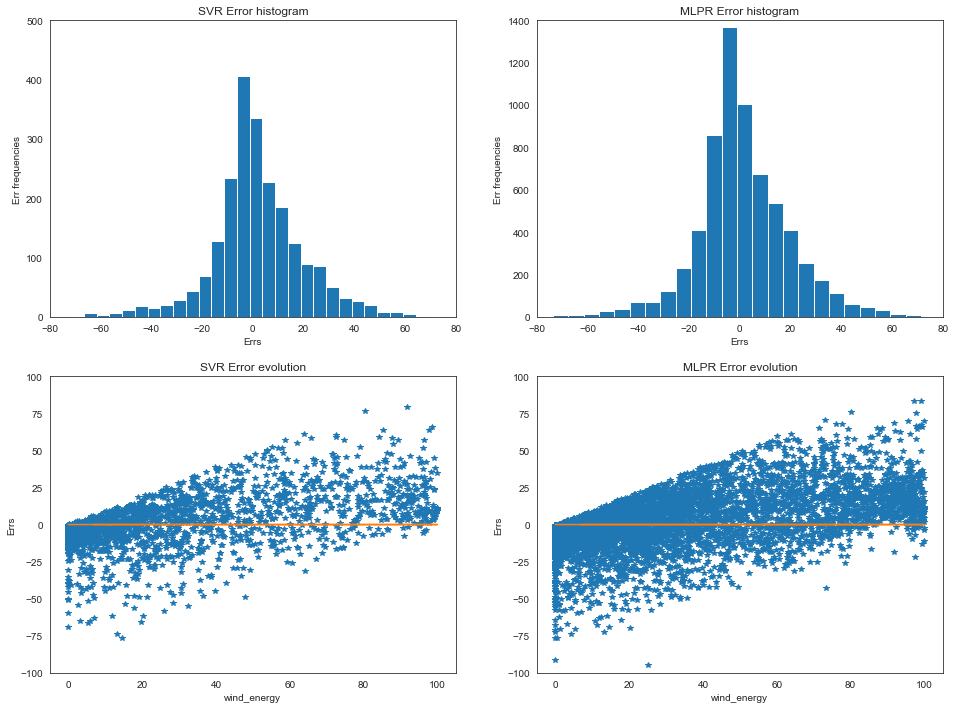

In [44]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 2)
plt.title("MLPR Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-80, 80)
plt.ylim(0, 1400)
_ = plt.hist(y - y_pred_mlp_cv, bins=31)

plt.subplot(2, 2, 1)
plt.title("SVR Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-80, 80)
plt.ylim(0, 500)
_ = plt.hist(y_sample - y_pred_svr, bins=31)


plt.subplot(2, 2, 4)
plt.title("MLPR Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
plt.ylim(-100, 100)
_ = plt.plot(y, y - y_pred_mlp_cv, '*', y, 0.*y, '-')


plt.subplot(2,2,3)
plt.title("SVR Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
plt.ylim(-100, 100)
_ = plt.plot(y_sample, y_sample - y_pred_svr, '*', y, 0.*y, '-')

plt.show()

Analyzing the distribution of errors through the histograms, we must bear in mind that we cannot compare according to absolute values because SVR was trained with a smaller amount of data than MLP. Even so, the two histograms show a very similar distribution, recurring again in that there are more observations where the errors are positive, which means that the model under estimates the predictions more often than over estimates them. Same can be seen in the scatter plot below, both models under estimates ans over estimates the predictions for small and big wind energy values.

In practice, it is not enough that one error is less than another to affirm that a model is better or worse. What really defines is if the MAE is significantly larger or lower, it would be convenient to perform a statistical test to compare the distribution of errors and check it in a analytical way.

# Trying to improve the estimator

We try to improve the MLPR and SVR results by enlarging the features set with the square and cube powers of the absolute velocities, reding the previous MLPR and SVR analysis and conclusions over the enlarged dataset with the same analysis structure. We show a sample ofthe new data.

In [45]:
df_large = df.copy()

df_large[['sqr_v10']] = df[['v10']]**2
df_large[['sqr_v100']] = df[['v100']]**2
df_large[['cub_v10']] = df[['v10']]**2
df_large[['cub_v100']] = df[['v100']]**3

# square_abs_vel_10 = df[['v10']]**2
# square_abs_vel_100 = df[['v100']]**2
# cube_abs_vel_10 = df[['v10']]**2
# cube_abs_vel_100 = df[['v100']]**3

In [46]:
df_large.head()

,U10,V10,U100,V100,v10,v100,target,sqr_v10,sqr_v100,cub_v10,cub_v100
TIMESTAMP,,,,,,,,,,,
2012-01-01 01:00:00,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,0.000000,11.706869,21.644209,11.706869,100.696084
2012-01-01 02:00:00,2.521695,-1.796960,3.344859,-2.464761,3.096451,4.154892,5.487912,9.588009,17.263129,9.588009,71.726437
2012-01-01 03:00:00,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,11.023400,7.817238,13.783229,7.817238,51.171302
2012-01-01 04:00:00,2.457504,-0.143642,3.215233,-0.355546,2.461699,3.234831,16.511606,6.059961,10.464133,6.059961,33.849706
2012-01-01 05:00:00,2.245898,0.389576,2.957678,0.332701,2.279435,2.976332,15.694013,5.195826,8.858551,5.195826,26.365988


In [47]:
l_vars_lg = list(l_vars) + ['sqr_v10', 'sqr_v100', 'cub_v10', 'sqr_v100']
x_large = df_large[l_vars_lg]
y_large = df_large[['target']]

## MLPR model over enlarged features

In this section we perform the same model than before but over the modified dataset. As we did before we perform a MLPRegressor using GridSearch to optimize hyperparameters and a pipelined MLPR over three folds over the entire sample. We have selected as optimizable params, the `alpha` and the hidden layer sizes, as it can be seen in the nect lines.

In [48]:
# select alpha in mlp regression by CV
n_folds = 3
kf = KFold(n_folds, shuffle=False)

mlpr =  MLPRegressor(activation='relu', 
                     solver='lbfgs', 
                     early_stopping=True,
                     tol=1.e-3, 
                     max_iter=10000)

regr = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('mlp', mlpr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

l_alpha = [10.**k for k in range(-6, 7)]
param_grid = {'regressor__mlp__alpha': l_alpha,
             'regressor__mlp__hidden_layer_sizes': [(20,), (20, 20), (20, 20, 20)]}  


cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=kf, 
                            scoring='neg_mean_absolute_error',
                            return_train_score=True,
                            refit=True,
                            n_jobs=-1, 
                            verbose=1)

t_0 = time.time()
cv_estimator.fit(x_large, y_large)
t_1 = time.time() 
print("\nmlp_grid_search_time: %.2f" % ((t_1 - t_0)/60.))
        
# saving alpha_search in a pickle    
f_name = 'mlp_large_search_results.joblib'
joblib.dump(cv_estimator, f_name, compress=3)

Fitting 3 folds for each of 39 candidates, totalling 117 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed: 12.3min finished



mlp_grid_search_time: 12.31


['mlp_large_search_results.joblib']

In [49]:
cv_estimator = joblib.load('mlp_large_search_results.joblib')

print("alpha_range: %.2f - %.2f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('best_alpha = %.2f' % (cv_estimator.best_params_['regressor__mlp__alpha']))
print('----------')

print(f"layer_sizes = {[(20,), (20, 20), (20, 20, 20)]}" )
best_size = cv_estimator.best_params_['regressor__mlp__hidden_layer_sizes']
print(f'best_hidden_layer_sizes = {best_size}')
print('----------')

print('best_cv_mae = %.3f' % (-cv_estimator.best_score_))

alpha_range: 0.00 - 1000000.00
best_alpha = 10.00
----------
layer_sizes = [(20,), (20, 20), (20, 20, 20)]
best_hidden_layer_sizes = (20,)
----------
best_cv_mae = 13.398


We have reached a mean absolute error still high. In the next table we show the hyperparameter configurations that lower error reaached during training. 

In [50]:
sv_search = pd.DataFrame.from_dict(cv_estimator.cv_results_)
sv_search.sort_values(by='mean_test_score', ascending=False)[['param_regressor__mlp__alpha',\
                                                                      'param_regressor__mlp__hidden_layer_sizes',\
                                                                      'mean_test_score',
                                                                       'mean_train_score']][:5]

,param_regressor__mlp__alpha,param_regressor__mlp__hidden_layer_sizes,mean_test_score,mean_train_score
21,10,"(20,)",-13.397536,-12.101378
22,10,"(20, 20)",-13.415718,-11.806068
23,10,"(20, 20, 20)",-13.534081,-11.520987
6,0.0001,"(20,)",-13.820435,-11.437641
12,0.01,"(20,)",-13.860526,-11.365462


In the next feature, we can see the `alpha` evolution during training. As we can see the grid search has selected the value that minimizes the mae.

In [51]:
# plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
# _ = plt.plot( -cv_estimator.cv_results_['mean_test_score'])

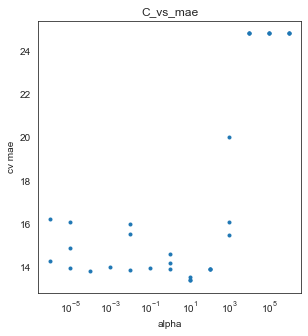

In [70]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.title('C_vs_mae')
plt.xlabel('alpha')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot(sv_search['param_regressor__mlp__alpha'], -sv_search['mean_test_score'], '.')

In the next three graphics we plot the predicted values and the real ones, also we show the error distributons in an histogram and the real wind energy values against each point error. 

In [53]:
y_large_pred_mlp_cv = np.clip( cross_val_predict(cv_estimator.best_estimator_, x_large, y_large, cv=kf, n_jobs=-1), 0., 200.)

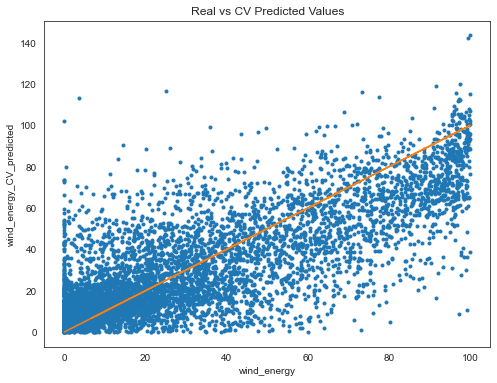

In [54]:
plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_CV_predicted')
_ = plt.plot(y_large, y_large_pred_mlp_cv, '.', y_large, y_large, '-')

mae: 13.452


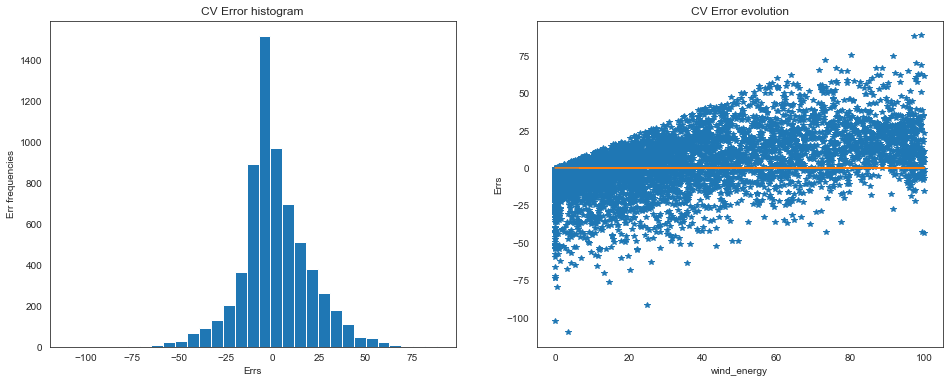

In [55]:
err = y_large - y_large_pred_mlp_cv

print("mae: %.3f" % (abs(err).mean()) )

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
_ = plt.plot(y_large, err, '*', y_large, 0.*y_large, '-')

plt.show()

## Conclusions on the enlarged MLPR model

If we compared the first scatter plot with the obtained using the original data, we can note that there are some values that are farther from the diagonal than before, which means that there are points with a visibly larger error. We have reached an slightly bigger error, but we can not affirm with confidence that this model is worse. On the other hand, the histogram shows a larger amount of errors concentrated close to cero, more than 1400, when in the previous MLP model we do not reach that number. This means that we have a bigger amount of points whose predicted value is closer to the real one than before. Tha last scatter plot keeps throwing the same conclusions about the model being under-estimating and over-estimating values.  

## SVR model over enlarged features

This section follows the same pattern of analysis as that of the previous SVR model. Initially, the model is trained through a grid search to optimize the c, alpha and epsilon parameters. In this case, as in the previous one, only a sample of the data set is taken to reduce traiing time.

In [56]:
df_large_sample = df_large.resample('3H').first()
df_large_sample.head(10)

,U10,V10,U100,V100,v10,v100,target,sqr_v10,sqr_v100,cub_v10,cub_v100
TIMESTAMP,,,,,,,,,,,
2012-01-01 00:00:00,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,0.000000,11.706869,21.644209,11.706869,100.696084
2012-01-01 03:00:00,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,11.023400,7.817238,13.783229,7.817238,51.171302
2012-01-01 06:00:00,1.986038,0.796304,2.655406,0.882648,2.139730,2.798258,16.878113,4.578446,7.830248,4.578446,21.911056
2012-01-01 09:00:00,-1.380191,2.903624,-3.048145,6.041520,3.214959,6.766916,15.318109,10.335960,45.791152,10.335960,309.864883
2012-01-01 12:00:00,-2.340389,0.617855,-6.095209,1.564929,2.420571,6.292899,14.782445,5.859165,39.600575,5.859165,249.202408
2012-01-01 15:00:00,-2.020323,-0.455396,-5.185562,-1.845935,2.071012,5.504319,24.104877,4.289090,30.297526,4.289090,166.767242
2012-01-01 18:00:00,-0.234062,-3.575916,0.028920,-8.864540,3.583568,8.864587,25.345362,12.841963,78.580900,12.841963,696.587217
2012-01-01 21:00:00,0.431304,-3.920464,1.175177,-8.187682,3.944117,8.271588,73.545717,15.556062,68.419174,15.556062,565.935249
2012-01-02 00:00:00,1.468088,-5.200273,2.254640,-7.688174,5.403529,8.011955,76.045483,29.198127,64.191418,29.198127,514.298731


Subsequently, once a model has been trained, the values of the parameters considered their best value are listed.

In [57]:
x_large_sample = df_large_sample[l_vars_lg].values
y_large_sample = df_large_sample[['target']].values.reshape(-1,)
num_patterns, dim = x_large_sample.shape
num_patterns, dim

(2193, 10)

In [58]:
l_C     = [10.**k for k in range(-3, 4)] 
l_gamma = list( np.array([2.**k for k in range(-2, 7)]) / dim)
l_epsilon = [2.**k for k in range(-6, 0)]

param_grid ={'regressor__svr__C': l_C,
             'regressor__svr__gamma': l_gamma,
             'regressor__svr__epsilon': l_epsilon}

print("num_hyperparams", len(l_C) * len(l_gamma) * len(l_epsilon))

mm_sc = MinMaxScaler()
svr = SVR(kernel='rbf', 
          shrinking=False, 
          tol=1.e-3)

regr = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                       ('svr', svr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=kf, 
                            scoring='neg_mean_absolute_error', 
                            refit=True,
                            n_jobs=-1,
                            return_train_score=True,
                            verbose=1)

t_0 = time.time()
cv_estimator.fit(x_large_sample, y_large_sample)
print("grid_search_time: %f segundos" % (time.time() - t_0))

f_pkl = open("c_gamma_epsilon_cv_search_energy_wind_large.pkz", 'wb') 
pickle.dump(cv_estimator, f_pkl)
f_pkl.close()

num_hyperparams 378
Fitting 3 folds for each of 378 candidates, totalling 1134 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 1134 out of 1134 | elapsed:  6.1min finished


grid_search_time: 364.879028 segundos


In [59]:
f_pkl = open("c_gamma_epsilon_cv_search_energy_wind_large.pkz", 'rb') 
cv_estimator = pickle.load(f_pkl)
f_pkl.close()

In [60]:
print("C_range: %.4f - %.0f" % (np.array(l_C).min(), np.array(l_C).max()))
print("\tbest_C:", cv_estimator.best_params_['regressor__svr__C']) 

print("gamma_range: %.5f - %.5f" % (np.array(l_gamma).min(), np.array(l_gamma).max()))
print("\tbest_gamma:", cv_estimator.best_params_['regressor__svr__gamma'])

print("epsilon_range: %.5f - %.3f" % (np.array(l_epsilon).min(), np.array(l_epsilon).max()))
print("\tbest_epsilon:", cv_estimator.best_params_['regressor__svr__epsilon'])

C_range: 0.0010 - 1000
	best_C: 1.0
gamma_range: 0.02500 - 6.40000
	best_gamma: 3.2
epsilon_range: 0.01562 - 0.500
	best_epsilon: 0.015625


This table represents the errors reached by the best five configurationn of params showing that the best mae is close to 13.06, which is high but lower that the reached by the previous model. 

In [61]:
df_C_gamma_epsilon_search = pd.DataFrame.from_dict(cv_estimator.cv_results_)
df_C_gamma_epsilon_search.sort_values(by='mean_test_score', ascending=False)[['param_regressor__svr__C',\
                                                                      'param_regressor__svr__gamma',\
                                                                      'param_regressor__svr__epsilon',\
                                                                      'mean_test_score']][ : 5]

,param_regressor__svr__C,param_regressor__svr__gamma,param_regressor__svr__epsilon,mean_test_score
169,1,3.2,0.015625,-13.005909
196,1,3.2,0.125,-13.033131
178,1,3.2,0.03125,-13.038662
187,1,3.2,0.0625,-13.040796
249,10,1.6,0.125,-13.062384


We also show the three graphs that show the progress of the model during training based on each of the optimizable parameters.

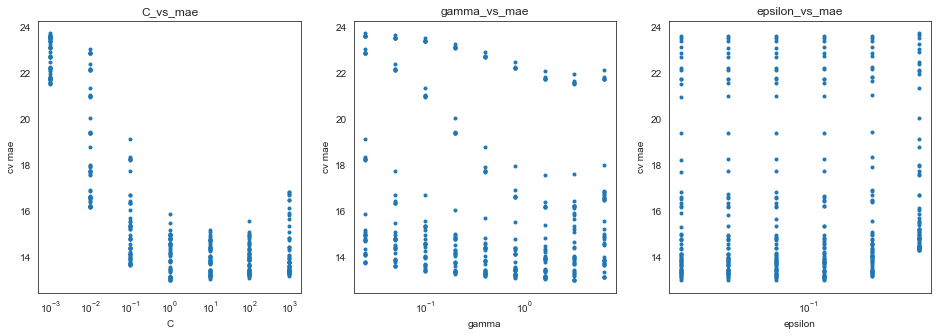

In [62]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.title('C_vs_mae')
plt.xlabel('C')
plt.ylabel('cv mae')
plt.xscale('log')
#plt.ylim(1.8, 2.2)
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__C'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 2)
plt.title('gamma_vs_mae')
plt.xlabel('gamma')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__gamma'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 3)
plt.title('epsilon_vs_mae')
plt.xlabel('epsilon')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__epsilon'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.show()

As we have discussed before, each time the grid search select the param that best fits the data, trying to avoid underfit and overfit. Again we can see that the parameter `alpha` seems ti have a direct effect on model performance, in the case of `gamma` and `epsilon` the influence is not as clear. Let´s analyze the model performsn in function of the predicted values. As always the graphics show the predicted values and the real ones, the error distribution and the erorrs against the real values.

In [63]:
best_estimator = cv_estimator.best_estimator_

scores = cross_val_score(best_estimator, x_large_sample,y_large_sample, scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))

mae_mean: 13.006		mae_std: 1.514


In [64]:
y_large_pred_svr = np.clip( cross_val_predict(best_estimator,  x_large_sample, y_large_sample, cv=kf, n_jobs=-1), 0., 200.)

print("mae: {0:.3f}".format(mean_absolute_error( y_large_sample, y_large_pred_svr)))

mae: 12.999


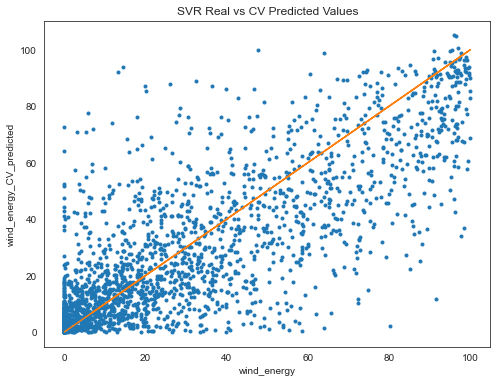

In [65]:
plt.figure( figsize=(8,6))

plt.title('SVR Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_CV_predicted')
_ = plt.plot( y_large_sample, y_large_pred_svr, '.', y_large_sample, y_large_sample, '-')

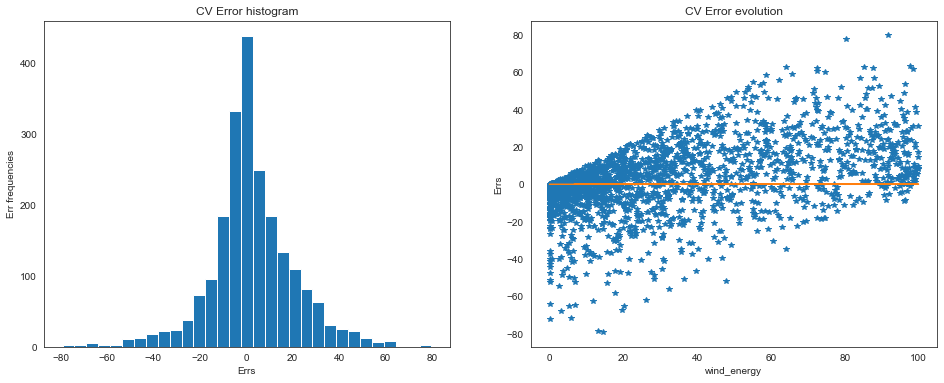

In [66]:
err =  y_large_sample - y_large_pred_svr

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
_ = plt.plot(y_large_sample, err, '*', y_large_sample, 0.*y_large_sample, '-')

plt.show()

## Conclusions on the enlarged SVR model

The first scatter plot is very similar to the one corresponding to the previous model. Analyzing the histogram that shows the distribution of the errors, we can see that it is also similar to that seen previously in the SVR model. Although the mean of the errors is close to zero, the model gets wrong for multiple observations and remains the behaviour of under/over-estimation of real values.

## MLP and SVR enlarged comparison

In this secton we compare thw last enlarged models based on the error an the error. We also have into account the distribution of error and the plots related to real and predicted values as well as the real and the error for each observation in the dataset. As we can see the model SVR outperforms the MLPR in terms of error, however, as it has been discused before in a real world problem  this is not enough to affirm that one model is better than the other. 

In [67]:
print("mlpr_mae: {0:.3f}".format(mean_absolute_error(y_large, y_large_pred_mlp_cv)))
print("svr_mae: {0:.3f}".format(mean_absolute_error( y_large_sample, y_large_pred_svr)))

mlpr_mae: 13.452
svr_mae: 12.999


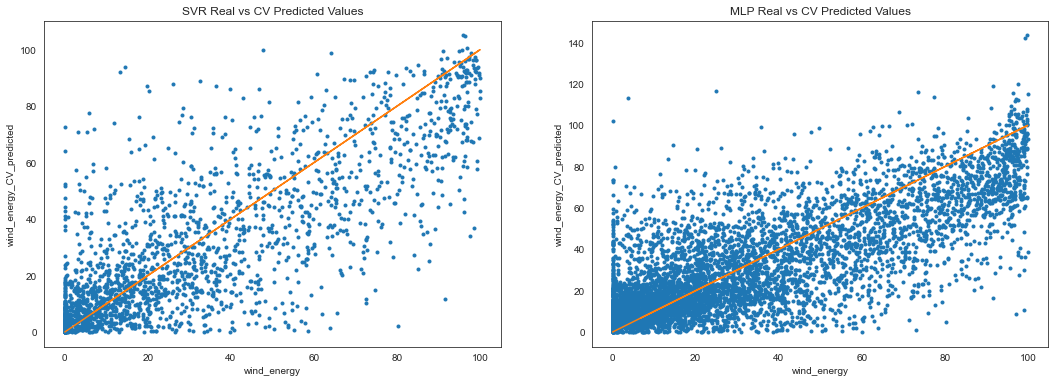

In [68]:
plt.figure( figsize=(18,6))

plt.subplot(1, 2, 1)
plt.title('SVR Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_CV_predicted')
_ = plt.plot(y_large_sample, y_large_pred_svr, '.', y_large_sample, y_large_sample, '-')

plt.subplot(1, 2, 2)
plt.title('MLP Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_CV_predicted')
_ = plt.plot(y_large, y_large_pred_mlp_cv, '.', y_large, y_large, '-')

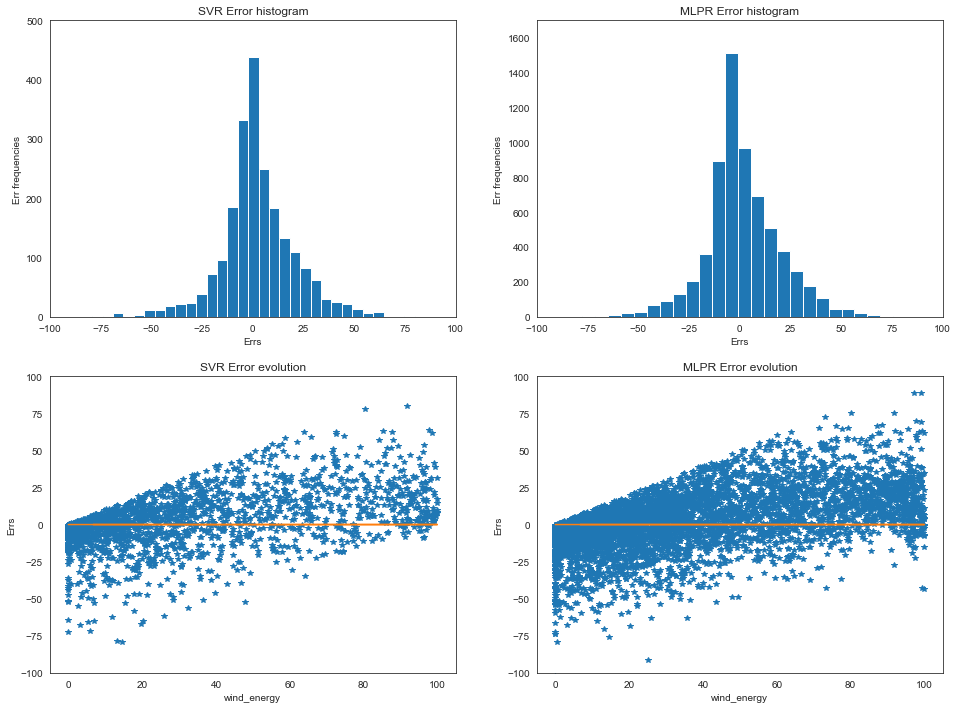

In [75]:
plt.figure( figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.title("SVR Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-100, 100)
plt.ylim(0, 500)
_ = plt.hist(y_large_sample - y_large_pred_svr, bins=31)

plt.subplot(2, 2, 2)
plt.title("MLPR Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-100, 100)
plt.ylim(0, 1700)
_ = plt.hist(y_large - y_large_pred_mlp_cv, bins=31)

plt.subplot(2,2,3)
plt.title("SVR Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
plt.ylim(-100, 100)
_ = plt.plot(y_large_sample, y_large_sample - y_large_pred_svr, '*', y_large_sample, 0.*y_large_sample, '-')

plt.subplot(2, 2, 4)
plt.title("MLPR Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
plt.ylim(-100, 100)
_ = plt.plot(y_large, y_large - y_large_pred_mlp_cv, '*', y_large, 0.*y_large, '-')

plt.show()

After analysing the graphics, we can say that the models shows a very similar performance, taking into account that the datasets were slightly different and we can not compare certainly based on absolute values. The graphics seems very similar and both models are subject to the fact that there are more observations where the errors are positive, which means that the model under estimates the predictions more often than over estimates them. Same can be seen in the scatter plot below, both models under estimates and over estimates the predictions for small and big wind energy values.

as it has been said before, in practice, this is not enough to compare models and the it would be convenient to perform a statistical test to compare the distribution of errors and check it in a analytical way.

# Final conclusions

In this work, a set of supervised learning models, specifically regression models, have been developed. A Ridge regressor has been used as a benchmark to compare with the neural network and support machine models, which are really the main ones. The starting point was a set of 6 predictor variables and later, the dataset was enlarged by adding transformed variables. Although the models proposed outperform the benchmark in terms of mean absolute eror, the proposed models reached a very large error on the test set. Taking into account that the SVR is far more expense in terms of time and resources to train that a MLP regressor and the model performances were not so different, we can say in this particular case it would be agood idea to erform a MLP regressor. However, it always depens on the particular escenario. It can be concluded that the models considered do not have sufficient capacity to solve this problem. In other words, it could also be stated that the predictor variables that were taken into account, all related to wind speed, are not sufficient to estimate wind energy. Therefore, it is recommended for future work to try more powerful regression models and also build a richer data set that involves more significant variables. 

In [ ]:
end_time = time.time()
print("\Total time: %.2f" % ((end_time - start_time)/60.))